---
# cspell:disable
title: "Signalling games: from symbolic to referential"
subtitle: Lab 2 -- Computational language modelling and cognition
authors:
    - name: Tom Wainstain
    - name: Philippos Triantafyllou
date: today
date-format: long
lang: en
format:
    pdf:
        pdf-engine: lualatex
        documentclass: scrartcl
        fontsize: 16pt
        papersize: A3
        toccolor: blue
        classoption: 
            - "DIV=12"
            - "parskip=relative"
            - "titlepage=false"
        code-block-border-left: MediumBlue
        code-block-bg: WhiteSmoke
        template-partials:
            - "../_pandoc/doc-class.tex"
            - "../_pandoc/toc.tex"
            - "../_pandoc/before-title.tex"
toc: true
toc-depth: 3
number-depth: 3
number-sections: true
highlight-style: github
fig-cap-location: top
embed-resources: true
# cspell:enable
---

Please find the link to the Google Colab notebook here.

## Building a simple signalling game incrementally

### The simplest game

First signalling game. Simple, states and messages are integers.

The scenario is that of a two players signalling game with an environment (the "Nature") that selects a state. Given the state, Alice chooses a message and when Bob receives it he selects an action. In case Bob performs the action that matches the state chosen by nature, the cooperation game is a success otherwise it is a failure.

The game is characterized by:

 - the number of states $S$ available to Nature;
 - the number of messages $M$ available to Alice;
 - the number of actions $A$ available to Bob.

States, messages and actions are represented by vectors of positive or null weights that are to be normalized before sampling. Since the weights are positive, one can normalize them straightforwardly: $$w_i = \frac{w_i}{\sum_{j=1}^k w_j}$$ for a vector $\mathbf{w}$ with length $k$.

In [55]:
import numpy as np

class SignallingGame:

    def __init__(self, states, messages, actions, seed=42):
        self.states = states
        self.messages = messages
        self.actions = actions
        self.message_weights = np.full((states, messages), 1e-6, dtype=float)
        self.action_weights = np.full((messages, actions), 1e-6, dtype=float)
        self.rng = np.random.RandomState(seed)
        self.stats = []


    def world_state(self):
        return self.rng.randint(self.states)


    def emit_message(self, state):
        w = self.message_weights[state, :]
        probs = w / np.sum(w)
        message = self.rng.choice(self.messages, p=probs)
        return message


    def perform_action(self, message):
        w = self.action_weights[message, :]
        probs = w / np.sum(w)
        action = self.rng.choice(self.actions, p=probs)
        return action


    def payoff(self, state, action):
        return 1 if action == state else 0


    def update_weights(self, state, message, action, payoff):
        self.message_weights[state, message] += payoff
        self.action_weights[message, action] += payoff


    def export_weights(self):
        return self.message_weights.copy(), self.action_weights.copy()


    def snapshot(self, state, message, action, payoff):
        mw, aw = self.export_weights()
        self.stats.append({
            "s": state,
            "m": message,
            "a": action,
            "p": payoff,
            "mw": mw,
            "aw": aw,
        })


    def play(self, N):
        for _ in range(N):
            state = self.world_state()
            message = self.emit_message(state)
            action = self.perform_action(message)
            payoff = self.payoff(state, action)
            self.update_weights(state, message, action, payoff)
            self.snapshot(state, message, action, payoff)

We take a snapshot at each episode to monitor the evolution of the strategies of both players.

In [56]:
#| echo: false

# Small function to get a quick look at the game stats, especially payoffs
def quick_look(game):
    payoffs = [x["p"] for x in game.stats]
    print("Number of rounds:", len(payoffs))
    print(f"Success rate: {sum(payoffs)/len(payoffs)*100:.2f}%")

For the simple games, we play 1000 rounds with 3 states, messages and actions. When we reach our real baseline we will increase the number of rounds to 100000.

In [57]:
game1 = SignallingGame(states=3, messages=3, actions=3)
game1.play(1000)
quick_look(game1) # Small function to get a quick look at the game stats, especially payoffs

Number of rounds: 1000
Success rate: 98.20%


### Roth-Erev update rule

Then we simply add the Roth-Erev update algorithm.

- $w_i = \lambda w_i + u$ if $i$ was chosen;
- $w_i = \lambda w_i$ if $i$ was not chosen;
- $w_i = \lambda w_i$ if $i$ was not sampled in this game;

where $u$ is the payoff and $\lambda \in [0,1]$.

In [58]:
class RothErevGame(SignallingGame):
    def __init__(self, states, messages, actions, l, seed=42):
        super().__init__(states, messages, actions, seed)
        self.l = l

    def update_weights(self, state, message, action, payoff):
        self.message_weights[state] *= self.l
        self.message_weights[(state, message)] += payoff
        self.action_weights[message] *= self.l
        self.action_weights[(message, action)] += payoff

In [59]:
game2 = RothErevGame(states=3, messages=3, actions=3, l=0.1)
game2.play(1000)
quick_look(game2)

Number of rounds: 1000
Success rate: 98.20%


### Minimal version of REINFORCE

Simple update to the original signalling game: just add a minimal version of the REINFORCE algorithm.

In [ ]:
import torch

class ReinforcedGame(SignallingGame):
    def __init__(self, states, messages, actions, lr, seed=42):
        super().__init__(states, messages, actions, seed)

        self.message_weights = torch.nn.Parameter(torch.zeros(states, messages))
        self.action_weights = torch.nn.Parameter(torch.zeros(messages, actions))
        self.optimizer = torch.optim.SGD([self.message_weights, self.action_weights], lr=lr)


    def emit_message(self, state):
        with torch.no_grad():
            probs = torch.softmax(self.message_weights[state], dim=-1)
            message = self.rng.choice(self.messages, p=probs.cpu().numpy())
        return message


    def perform_action(self, message):
        with torch.no_grad():
            probs = torch.softmax(self.action_weights[message], dim=-1)
            action = self.rng.choice(self.actions, p=probs.cpu().numpy())
        return action


    def update_weights(self, state, message, action, payoff):
        reward = torch.tensor(float(payoff))

        # Alice's loss
        log_probs_m = torch.log_softmax(self.message_weights[state], dim=-1)[message]
        loss_m = -reward * log_probs_m

        # Bob's loss
        log_probs_a = torch.log_softmax(self.action_weights[message], dim=-1)[action]
        loss_a = -reward * log_probs_a

        loss = loss_m + loss_a
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def export_weights(self):
        return (
            self.message_weights.detach().cpu().numpy().copy(),
            self.action_weights.detach().cpu().numpy().copy(),
        )

Note that our implementation is not very optimal, we redundantly compute the probabilities of the messages and actions multiple times. This is done for clarity.

In [61]:
game3 = ReinforcedGame(states=3, messages=3, actions=3, lr=0.5)
game3.play(1000)
quick_look(game3)

Number of rounds: 1000
Success rate: 92.00%


### Batch REINFORCE

We update the algorithm to use batch updates for more stable learning.

In [62]:
class ReinforcedGameBatch(ReinforcedGame):
    def __init__(self, states, messages, actions, lr, batch_size, seed=42):
        super().__init__(states, messages, actions, lr, seed)
        self.batch_size = batch_size


    def run_batch(self, batch_n):
        self.optimizer.zero_grad()
        batch_loss = torch.tensor(0.0)

        for _ in range(batch_n):
            state = self.world_state()
            message = self.emit_message(state)
            action = self.perform_action(message)
            payoff = self.payoff(state, action)

            r = torch.tensor(float(payoff))
            log_probs_m = torch.log_softmax(self.message_weights[state], dim=-1)[message]
            log_probs_a = torch.log_softmax(self.action_weights[message], dim=-1)[action]
            batch_loss += -r * (log_probs_m + log_probs_a)
            self.snapshot(state, message, action, payoff)

        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play(self, N):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)

Batch updates get slower updates, for such a small example, it actually decreases performance. We can increase the learning rate to compensate, but SGD can only go so far. We can increase the number of games from 1000 to 10000 to get better results.

In [51]:
game4 = ReinforcedGameBatch(states=3, messages=3, actions=3, lr=0.5, batch_size=5)
game4.play(10000)
quick_look(game4)

Number of rounds: 10000
Success rate: 94.62%


## Baseline: symbolic signalling game with REINFORCE

Now that we have a working signalling game template with a minimal working REINFORCE algorithm, we can go one step higher and complexity the game.

### The idea

The game context is that of Referential games where Nature shows some pictures to Alice and chooses one of them as the target. Then Alice has to send a message to Bob telling which picture she has seen in the list. Bob sees the list of pictures in the same order and has to guess which one Nature had chosen. In our case the pictures will be digits from 0 to 9 coloured in red, green, blue or white and of different sizes: small, medium and large.

Practically, at each round, Nature generates a state composed of $K$ objects. Each object is represented by a triple $(d,c,s) \in \mathcal D \times \mathcal C \times \mathcal S$, where $\mathcal D$, $\mathcal C$, and $\mathcal S$ are finite sets corresponding to digit, color, and size. One of the $K$ objects is selected uniformly at random as the target and its index is provided to Alice together with the full state.

Alice encodes the target object using three parameter matrices, one per attribute. The digit-message matrix has size $|\mathcal D| \times V$, the color-message matrix has size $|\mathcal C| \times V$, and the size-message matrix has size $|\mathcal S| \times V$, where $V$ is the message vocabulary size. Given a target with attributes $(d,c,s)$, Alice selects row $d$, $c$, and $s$ from the corresponding matrices, applies a softmax to each row, and samples one symbol from each resulting categorical distribution. The three sampled symbols form the message $m = (m_d,m_c,m_s)$ sent to Bob. The resulting message space $V^3$ is chosen to match the cardinality of the object space $|\mathcal D|\cdot|\mathcal C|\cdot|\mathcal S|$. This is the same as in the simple signalling games above where there was a one-to-one mapping between states, messages and actions.

Bob decodes the message using three decoding matrices with complementary dimensions: $V \times |\mathcal D|$, $V \times |\mathcal C|$, and $V \times |\mathcal S|$. For each object $i \in {1,\dots,K}$ with attributes $(d_i,c_i,s_i)$, Bob computes a score
$score(i) = W^{(d)}_{m_d, d_i} + W^{(c)}_{m_c, c_i} + W^{(s)}_{m_s, s_i}$,
yielding one scalar score per object.

Bob applies a softmax over these $K$ scores to obtain a distribution over object indices and samples one index as his guess. A reward $r \in {0,1}$ is then issued depending on whether the selected object matches the target. Both Alice and Bob update their parameters using a policy-gradient update proportional to $r$, so that when $r=0$ the gradient vanishes and no parameter update is performed.

### The implementation

In [ ]:
class SymbolicReinforcedGame():
    def __init__(self, K=3, state_dims=(10, 4, 3), lr=0.5, batch_size=20, seed=42):
        self.K = K
        self.state_dims = state_dims
        self.total_states = np.prod(state_dims)
        self.lr = lr
        self.batch_size = batch_size
        self.stats = []

        # Random seeds for reproducibility
        self.rng = np.random.RandomState(seed)
        torch.manual_seed(seed)   

        # Alice learns a separate categorical policy for each symbolic attribute
        # Alice's weights - separate matrix for each message component
        self.message_digit_weights = torch.nn.Parameter(torch.zeros(state_dims[0], state_dims[0]))
        self.message_color_weights = torch.nn.Parameter(torch.zeros(state_dims[1], state_dims[1]))
        self.message_size_weights = torch.nn.Parameter(torch.zeros(state_dims[2], state_dims[2]))

        # Bob learns how message symbols map back to object attributes
        # Bob's weights - separate matrix for each action component
        self.action_digit_weights = torch.nn.Parameter(torch.zeros(state_dims[0], state_dims[0]))
        self.action_color_weights = torch.nn.Parameter(torch.zeros(state_dims[1], state_dims[1]))
        self.action_size_weights = torch.nn.Parameter(torch.zeros(state_dims[2], state_dims[2]))

        # Single optimizer jointly updates Alice and Bob parameters
        self.optimizer = torch.optim.SGD([
            self.message_digit_weights,
            self.message_color_weights,
            self.message_size_weights,
            self.action_digit_weights,
            self.action_color_weights,
            self.action_size_weights,
        ], lr=lr)


    def world_state(self):
        # Sample a random set of K objects and designate one as the target
        state = []
        for _ in range(self.K):
            digit = self.rng.randint(self.state_dims[0])
            color = self.rng.randint(self.state_dims[1])
            size = self.rng.randint(self.state_dims[2])
            state.append((digit, color, size))

        target_index = self.rng.randint(self.K)
        return state, target_index


    def emit_message(self, state, target_index):
        # Alice encodes the target object by sampling one symbol per attribute
        target = state[target_index]

        digit_logits = self.message_digit_weights[target[0]]
        color_logits = self.message_color_weights[target[1]]
        size_logits  = self.message_size_weights[target[2]]

        # Each attribute is modelled as an independent categorical policy
        digit_dist = torch.distributions.Categorical(logits=digit_logits)
        color_dist = torch.distributions.Categorical(logits=color_logits)
        size_dist  = torch.distributions.Categorical(logits=size_logits)

        digit = digit_dist.sample()
        color = color_dist.sample()
        size  = size_dist.sample()

        # Sum log-probabilities to obtain Alice's total message log-likelihood
        log_prob = ( digit_dist.log_prob(digit) + color_dist.log_prob(color) + size_dist.log_prob(size) )
        message = (digit.item(), color.item(), size.item())
        return message, log_prob


    def perform_action(self, message, state):
        # Bob scores each object by matching message symbols to object attributes
        scores = []
        for obj in state:
            digit_score = self.action_digit_weights[message[0], obj[0]]
            color_score = self.action_color_weights[message[1], obj[1]]
            size_score  = self.action_size_weights[message[2], obj[2]]
            scores.append(digit_score + color_score + size_score)

        # Stack scores into a single tensor
        scores = torch.stack(scores)
        
        # Convert object scores into a stochastic choice over indices
        dist = torch.distributions.Categorical(logits=scores)

        # Sample an action (object index) and get its log-probability
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.item(), log_prob


    def payoff(self, target_index, action):
        return 1 if action == target_index else 0


    def run_batch(self, batch_n: int):
        # Run a batch of games and estimate the REINFORCE gradient
        self.optimizer.zero_grad()
        batch_loss = torch.tensor(0.0)

        for _ in range(batch_n):
            state, target_index = self.world_state()
            message, log_prob_message = self.emit_message(state, target_index)
            action, log_prob_action = self.perform_action(message, state)
            payoff = self.payoff(target_index, action)
            self.snapshot(state, target_index, message, action, payoff)

            # Weight Alice and Bob log-probabilities by the observed reward
            reward = torch.tensor(float(payoff))
            batch_loss += -reward * (log_prob_message + log_prob_action)

        # Perform a single gradient update using the average batch loss
        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play_batch(self, N):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)


    def snapshot(self, state, target_index, message, action, payoff):
        msg_strategy, act_strategy = self.export_strategies()
        self.stats.append({
            "state": state,
            "target_index": target_index,
            "m": message,
            "a": action,
            "p": payoff,
            "msg_strategies": msg_strategy,
            "act_strategies": act_strategy,
        })


    def export_strategies(self):
        with torch.no_grad():
            # Messaging strategies: for each state feature, what message to send?
            message_strategies = {
                'digit': torch.softmax(self.message_digit_weights, dim=-1).cpu().numpy(), 
                'color': torch.softmax(self.message_color_weights, dim=-1).cpu().numpy(),
                'size': torch.softmax(self.message_size_weights, dim=-1).cpu().numpy(),
            }

            # Action strategies: for each message feature, what object feature to choose?
            action_strategies = {
                'digit': torch.softmax(self.action_digit_weights, dim=-1).cpu().numpy(), 
                'color': torch.softmax(self.action_color_weights, dim=-1).cpu().numpy(),
                'size': torch.softmax(self.action_size_weights, dim=-1).cpu().numpy(),
            }

            return message_strategies, action_strategies

In [72]:
game5 = SymbolicReinforcedGame(K=3, lr=0.5, batch_size=20)
game5.play_batch(100000)
quick_look(game5)

Number of rounds: 100000
Success rate: 87.25%


### Interpretation of the emergent messaging protocol

In [77]:
#| echo: false

import matplotlib.pyplot as plt

def plot_strategy_evolution(game, feature='digit', agent='message'):
    # Get number of features for this dimension
    feature_to_dim = {'digit': 0, 'color': 1, 'size': 2}
    num_features = game.state_dims[feature_to_dim[feature]]
    
    # Setup subplot grid
    ncols = 2
    nrows = (num_features + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
    axes = np.atleast_1d(axes).flatten()
    
    # Extract strategy key
    strategy_key = 'msg_strategies' if agent == 'message' else 'act_strategies'
    
    # Plot each state
    for state_idx in range(num_features):
        # Collect probability trajectories
        trajectories = [[] for _ in range(num_features)]
        
        for stat in game.stats:
            strategy = stat[strategy_key][feature]
            for option_idx in range(num_features):
                trajectories[option_idx].append(strategy[state_idx, option_idx])
        
        # Plot trajectories
        ax = axes[state_idx]
        label_prefix = 'm' if agent == 'message' else 'a'
        for option_idx, trajectory in enumerate(trajectories):
            ax.plot(trajectory, label=f'{label_prefix}{option_idx}')
        
        ax.set_title(f'State {state_idx}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Strategy Weights')
        ax.set_ylim([0, 1])
        ax.legend()
    
    # Hide unused subplots
    for idx in range(num_features, len(axes)):
        axes[idx].axis('off')
    
    # Add title
    agent_name = 'Messaging' if agent == 'message' else 'Action'
    condition = 'Nature' if agent == 'message' else 'Messaging'
    fig.suptitle(f'{agent_name} Strategies Given {condition} State ({feature}s)', fontsize=14, fontweight='bold')
    
    plt.tight_layout(rect=(0, 0, 1, 0.98))
    plt.show()

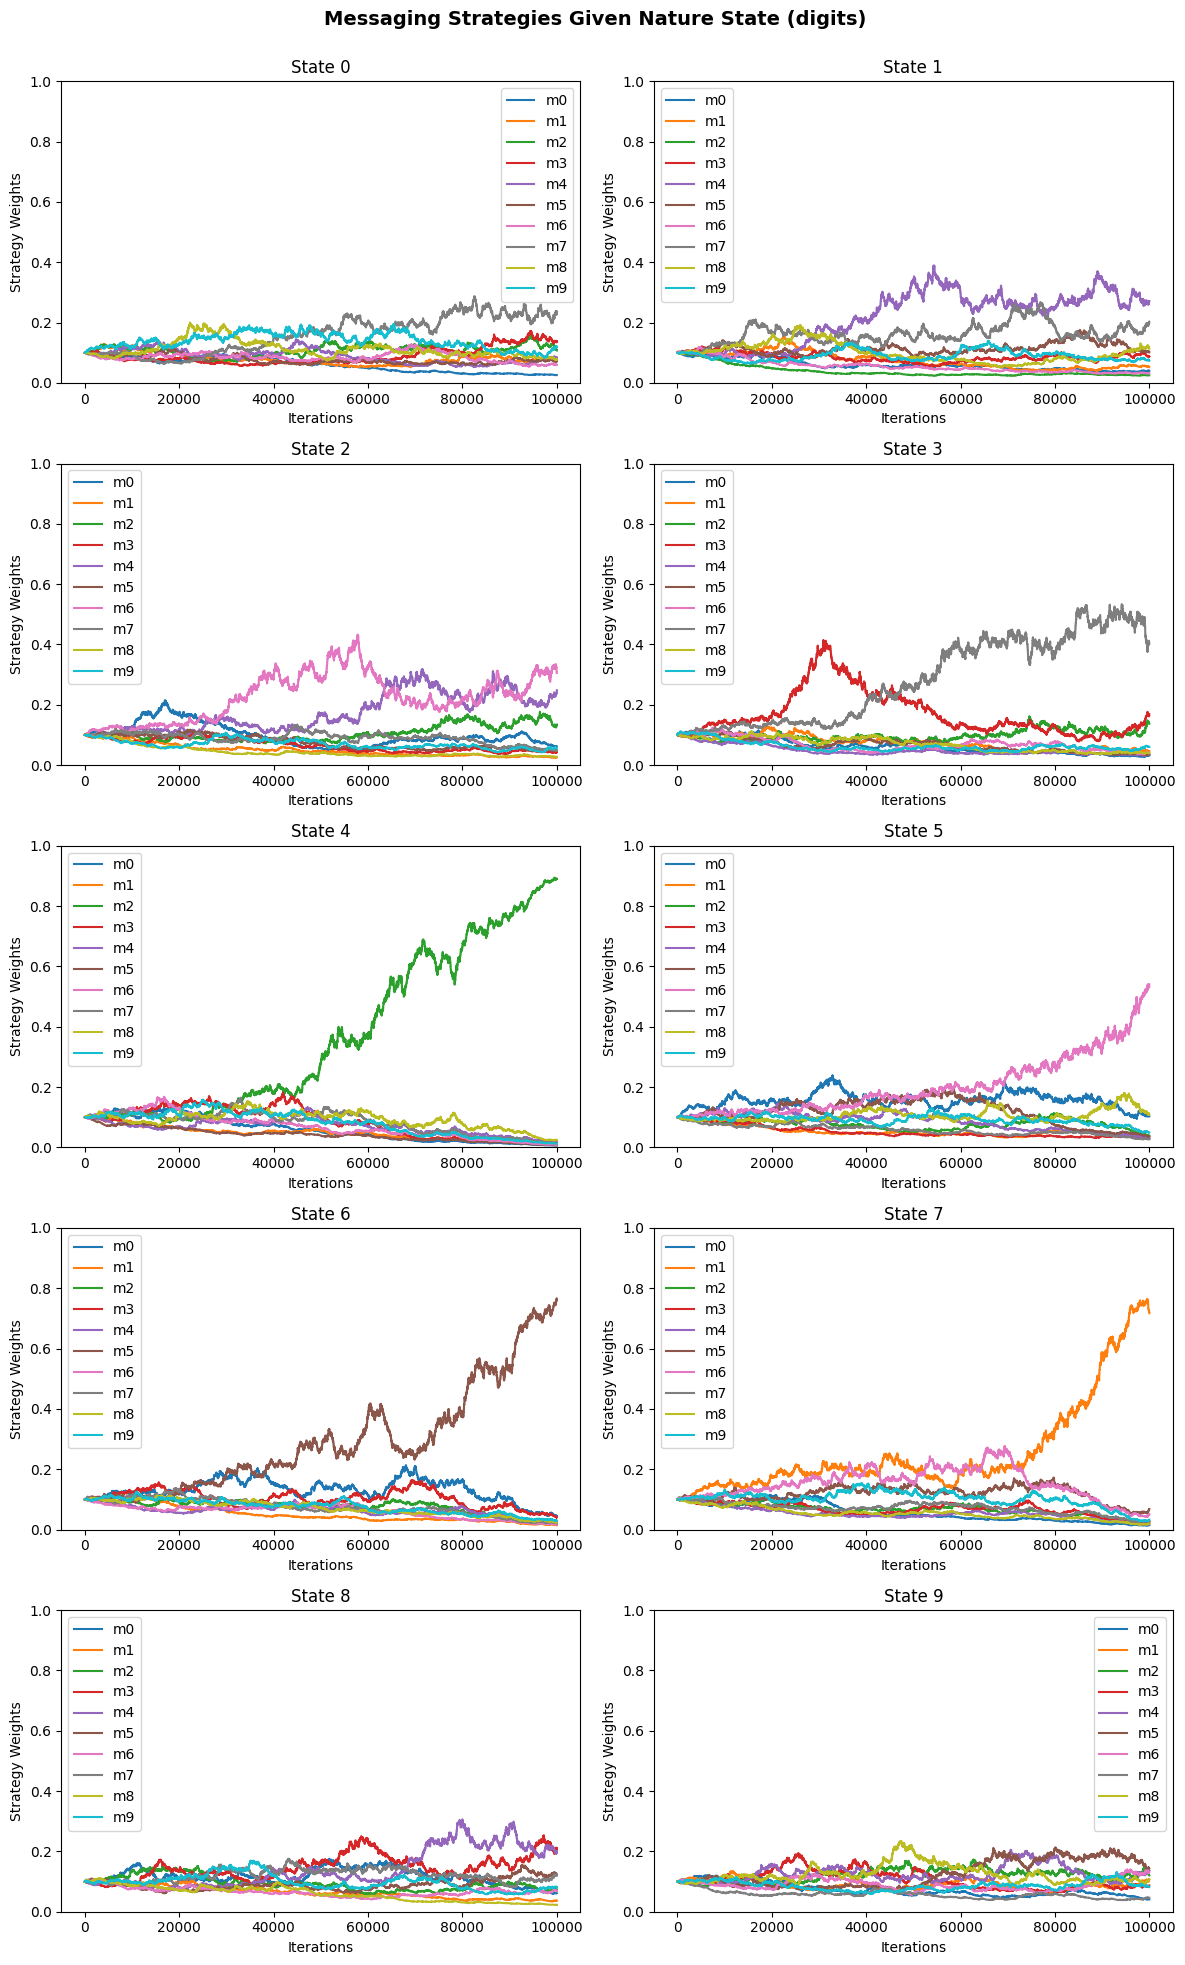

In [78]:
#| echo: false

plot_strategy_evolution(game5, feature='digit', agent='message')

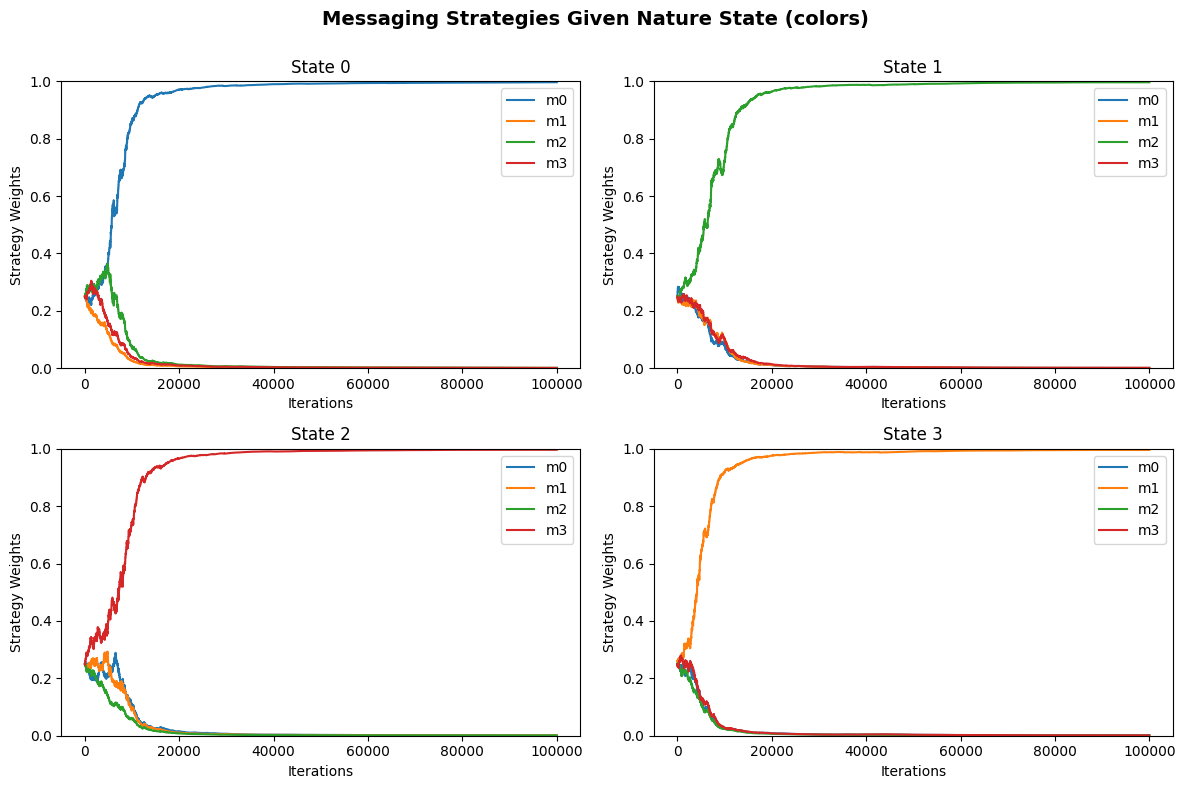

In [79]:
#| echo: false

plot_strategy_evolution(game5, feature='color', agent='message')

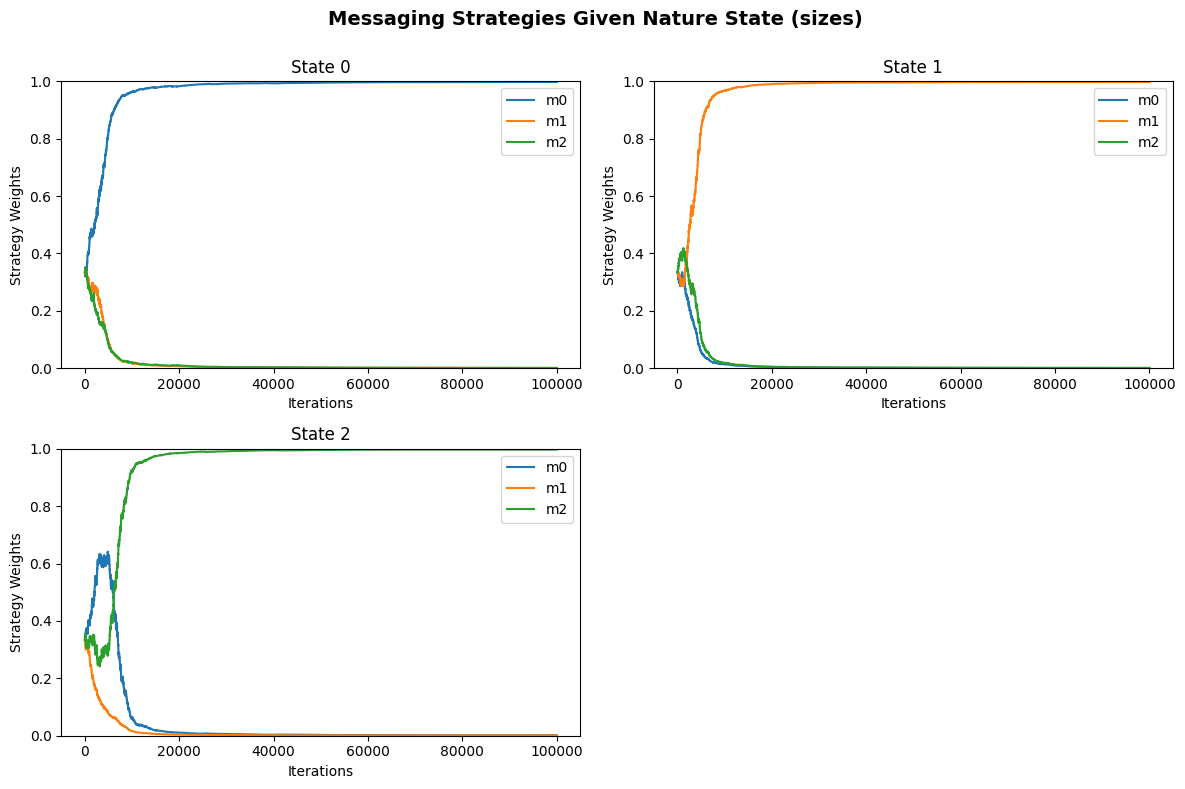

In [80]:
#| echo: false

plot_strategy_evolution(game5, feature='size', agent='message')

There are two questions to be answered: 1) Does the signalling game converge to a successful communication protocol? If yes, 2) Can we interpret the emergent protocol (the messages)?

To answer we simply save the evolution of the messaging strategies of Alice over time and plot them. If there is a communication protocol emerging, we should see that for each feature (digit, color, size), Alice learns to send specific messages for each value of the feature.

Looking at the above plots, there is a clear convergence of some features to specific messages. This is most strikingly the case for color and size, while digit is a bit more noisy. That means that looking randomly at the messages sent by Alice, the second and third symbols will correspond quite reliably to a color and size respectively, while the first symbol will less clearly be associated with a digit, as for some cases the weight matrix is still noisy after training.

## Extended baseline: symbolic game with sequential messages via LSTMs

This is the same exercise as the previous one. This time the message is a sequence of symbols generated by an LSTM language model. Alice generates a string and Bob has to encode it in a vector.

### The idea

Alice is implemented as an LSTM-based conditional sequence model. Each object attribute is first embedded into a continuous vector space: the digit, color, and size are mapped to vectors in $\mathbb{R}^{d}$, where $d$ is the embedding dimension. These three embeddings are concatenated to form a target representation in $\mathbb{R}^{3d}$. This vector is then passed through a learned linear projection to produce a vector in $\mathbb{R}^{h}$, where $h$ is the LSTM hidden dimension, and is used to initialize the hidden state of Alice’s LSTM. The LSTM cell state is initialized to zero.

Message generation is autoregressive and proceeds for a fixed number of steps $T$. At time step $t=1$, the input to the LSTM is not a message symbol but a learnable start-of-sequence vector in $\mathbb{R}^{3d}$. This vector is a trainable parameter and replaces a fixed zero input, allowing Alice to learn how to initiate message generation. For $t>1$, the input to the LSTM is the embedding of the previously sampled message symbol, taken from a learned token embedding matrix of size $V \times 3d$, where $V$ is the message vocabulary size. At each time step, the LSTM outputs a hidden state in $\mathbb{R}^{h}$, which is mapped through a linear layer to logits in $\mathbb{R}^{V}$. A categorical distribution is defined from these logits, and a message symbol $m_t \in {0,\dots,V-1}$ is sampled. The log-probabilities $\log p(m_t)$ are accumulated for learning.

Bob processes the received message using a separate LSTM. Each message symbol $m_t$ is first embedded into a vector in $\mathbb{R}^{h}$ using a learned embedding matrix of size $V \times h$. The sequence of embeddings is passed through Bob’s LSTM, and the final hidden state $h_B \in \mathbb{R}^{h}$ is taken as Bob’s representation of the message.

To score candidate objects, Bob embeds each object’s attributes in the same way as Alice, producing a vector in $\mathbb{R}^{3d}$. This vector is then passed through a learned linear projection into $\mathbb{R}^{h}$, yielding an object representation $o_i \in \mathbb{R}^{h}$. For each object $i$, Bob computes a scalar compatibility score given by the dot product $\langle h_B, o_i \rangle$. A softmax over the $K$ object scores defines a probability distribution over object indices, from which Bob samples one object as his prediction.

Importantly, weighting updates directly by the reward leads to high-variance and unstable gradients, since most episodes receive zero reward and successful ones dominate the learning signal. In order to fix this and stabilize training, the reward can replaced by an advantage term that subtracts a running baseline estimating the expected reward. This is an easier solution to implement and an intermediary to Actor Critic or PPO (inspired by [this blog post](https://johnwlambert.github.io/policy-gradients/#reinforce)). For this approach, in each episode the reward is a scalar $r \in {0,1}$. Instead of multiplying the policy-gradient term by $r$ directly, the code uses an advantage $A = r - b$, where $b$ is a running baseline. Concretely, the batch loss accumulates
$L = - (r - b) \times (\log p_A(m) + \log p_B(a))$,
so positive advantage increases the probability of the sampled message and action, while negative advantage decreases it. This reduces gradient variance while keeping the estimator unbiased, because the baseline does not depend on the sampled actions.

The baseline $b$ is updated once per batch using an exponential moving average of the batch mean reward. If $\bar r$ denotes the average reward over the current batch, the code performs
$b \leftarrow \beta b + (1-\beta)\bar r$,
where $\beta$ is the baseline decay parameter (baseline_decay). When $\beta$ is close to $1$, the baseline changes slowly and reflects long-term performance; when $\beta$ is smaller, the baseline tracks recent rewards more aggressively. In practice, this means the advantage term $r-b$ is centered around a smooth estimate of expected reward, stabilizing training and preventing updates from being dominated by short-term noise.

### The implementation

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

class LSTMReinforcedGame:
    def __init__(
        self,
        K=3,
        input_dims=(10, 4, 3),
        embedding_dim=64,
        hidden_dim=128,
        maximum_message_length=3,
        vocabulary_size=17,
        learning_rate=0.5,
        batch_size=100,
        seed=42,
        baseline_decay=0.99,
        use_baseline=True,
        use_adam=False,
    ):
        self.K = K
        self.batch_size = batch_size
        self.stats = []
        self.baseline = 0.0
        self.baseline_decay = baseline_decay
        self.use_baseline = use_baseline
        self.use_adam = use_adam

        # Set random seeds
        self.rng = np.random.RandomState(seed)
        torch.manual_seed(seed)

        # Alice's embeddings for object attributes (used for message generation)
        self.alice_digit_embedding = torch.nn.Embedding(input_dims[0], embedding_dim)
        self.alice_color_embedding = torch.nn.Embedding(input_dims[1], embedding_dim)
        self.alice_size_embedding = torch.nn.Embedding(input_dims[2], embedding_dim)

        # Bob's embeddings for object attributes (used for message decoding)
        self.bob_digit_embedding = torch.nn.Embedding(input_dims[0], embedding_dim)
        self.bob_color_embedding = torch.nn.Embedding(input_dims[1], embedding_dim)
        self.bob_size_embedding = torch.nn.Embedding(input_dims[2], embedding_dim)

        # Alice encodes the target object into a sequence of discrete message symbols
        self.alice_lstm = torch.nn.LSTM(input_size=embedding_dim * 3, hidden_size=hidden_dim, batch_first=True)
        self.alice_output_layer = torch.nn.Linear(hidden_dim, vocabulary_size)
        self.alice_hidden_state_projection = torch.nn.Linear(embedding_dim * 3, hidden_dim)
        self.alice_token_embedding = torch.nn.Embedding(vocabulary_size, embedding_dim * 3)
        # Learnable start-of-sequence vector for Alice
        self.alice_start_token = torch.nn.Parameter(torch.zeros(embedding_dim * 3))

        # Bob decodes the message and scores candidate objects in the state
        self.bob_encode_message = torch.nn.Embedding(vocabulary_size, hidden_dim)
        self.bob_lstm = torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.bob_object_projection = torch.nn.Linear(embedding_dim * 3, hidden_dim)

        # Maximum length of the message Alice can produce
        self.maximum_message_length = maximum_message_length

        # Vocabulary size for the messages
        self.vocabulary_size = vocabulary_size

        # Store input_dims explicitly
        self.input_dims = input_dims

        # Joint optimizer for Alice and Bob parameters using policy-gradient learning
        if self.use_adam:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)


    def parameters(self):
        # Yes... we have a lot of parameters...
        return [
            *self.alice_digit_embedding.parameters(),
            *self.alice_color_embedding.parameters(),
            *self.alice_size_embedding.parameters(),
            *self.bob_digit_embedding.parameters(),
            *self.bob_color_embedding.parameters(),
            *self.bob_size_embedding.parameters(),
            *self.alice_lstm.parameters(),
            *self.alice_output_layer.parameters(),
            *self.alice_hidden_state_projection.parameters(),
            *self.alice_token_embedding.parameters(),
            self.alice_start_token,
            *self.bob_encode_message.parameters(),
            *self.bob_lstm.parameters(),
            *self.bob_object_projection.parameters(),
        ]


    def world_state(self, K):
        # Generate a random world state with K objects
        state = []
        for _ in range(K):
            digit = self.rng.randint(0, self.input_dims[0])
            color = self.rng.randint(0, self.input_dims[1])
            size = self.rng.randint(0, self.input_dims[2])
            state.append((digit, color, size))
        target_index = self.rng.randint(0, K)
        return state, target_index


    def emit_message(self, state, target_index):
        # Alice generates a message by conditioning on the target object
        target_digit, target_color, target_size = state[target_index]

        # Embed the symbolic attributes of the target into a continuous representation
        digit_emb = self.alice_digit_embedding(torch.tensor(target_digit))
        color_emb = self.alice_color_embedding(torch.tensor(target_color))
        size_emb = self.alice_size_embedding(torch.tensor(target_size))
        target_embedding = torch.cat([digit_emb, color_emb, size_emb], dim=-1)

        # Initialize Alice’s recurrent state from the target representation
        projected_hidden = torch.tanh(self.alice_hidden_state_projection(target_embedding))
        h = projected_hidden.unsqueeze(0).unsqueeze(0)
        c = torch.zeros_like(h)
        hidden = (h, c)

        # Start token input to the LSTM
        input_token_embedding = self.alice_start_token.view(1, 1, -1)
        message = []
        log_probs = []

        # Autoregressively sample a sequence of message tokens from Alice’s policy
        for _ in range(self.maximum_message_length):
            output, hidden = self.alice_lstm(input_token_embedding, hidden)
            logits = self.alice_output_layer(output.squeeze(1))
            dist = torch.distributions.Categorical(logits=logits)
            token = dist.sample()
            log_probs.append(dist.log_prob(token))
            message.append(token.item())

            # Prepare the embedding of the sampled token for the next time step
            input_token_embedding = self.alice_token_embedding(token).unsqueeze(0)

        # Combine log probabilities of all sampled tokens
        message_log_probability = torch.stack(log_probs).sum()

        return message, message_log_probability


    def perform_action(self, message, state):
        # Bob selects an object by interpreting the received message
        # Convert message to tensor and get embeddings
        message_tensor = torch.tensor(message)
        message_embeddings = self.bob_encode_message(message_tensor)
        message_embeddings = message_embeddings.unsqueeze(0)

        # Initialize Bob's hidden and cell states
        h_0 = torch.zeros(1, 1, self.bob_lstm.hidden_size)
        c_0 = torch.zeros(1, 1, self.bob_lstm.hidden_size)

        # Encode the full message sequence into a fixed-length representation
        _, (h_n, _) = self.bob_lstm(message_embeddings, (h_0, c_0))
        bob_final_hidden = h_n[-1, 0]

        # Score each object by comparing message representation with object attributes
        scores = []
        for digit, color, size in state:
            # Embed object attributes
            digit_emb = self.bob_digit_embedding(torch.tensor(digit))
            color_emb = self.bob_color_embedding(torch.tensor(color))
            size_emb = self.bob_size_embedding(torch.tensor(size))
            
            # Combine embeddings and project
            object_vector = torch.cat([digit_emb, color_emb, size_emb], dim=-1)
            
            # Project object vector to match Bob's hidden state dimension
            projected_object = torch.tanh(self.bob_object_projection(object_vector))

            # Compute similarity score
            score = torch.dot(bob_final_hidden, projected_object)
            scores.append(score)

        # Convert scores to tensor
        scores_tensor = torch.stack(scores)

        # Apply softmax to get probabilities
        probs = torch.softmax(scores_tensor, dim=0)

        # Create categorical distribution and sample action
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        action_log_probability = dist.log_prob(action)

        return action.item(), action_log_probability


    def payoff(self, target_index, action):
        return 1.0 if target_index == action else 0.0


    def snapshot(self, state, target_index, message, action, payoff):
        target_digit, target_color, target_size = state[target_index]
        self.stats.append({
            "state": state,
            "target_index": target_index,
            "target": (target_digit, target_color, target_size),
            "m": message,
            "a": action,
            "p": payoff,
        })


    def run_batch(self, batch_size):
        self.optimizer.zero_grad()
        batch_loss = torch.tensor(0.0)
        total_reward = 0.0

        for _ in range(batch_size):
            # An episode of the game
            state, target_index = self.world_state(self.K)
            message, log_prob_A = self.emit_message(state, target_index)
            action, log_prob_B = self.perform_action(message, state)
            reward = self.payoff(target_index, action)
            self.snapshot(state, target_index, message, action, reward)

            # Accumulate rewards and log probabilities
            total_reward += reward
            if self.use_baseline:
                advantage = reward - self.baseline
            else:
                advantage = reward
            batch_loss = batch_loss + (-advantage * (log_prob_A + log_prob_B).squeeze())

        # Apply a single gradient update and update the reward baseline
        batch_loss = batch_loss / batch_size
        batch_loss.backward()
        self.optimizer.step()

        # Update baseline with exponential moving average
        avg_reward = total_reward / batch_size
        if self.use_baseline:
            self.baseline = (self.baseline_decay * self.baseline + (1 - self.baseline_decay) * avg_reward)

        return avg_reward


    def play_batch(self, N):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in tqdm(range(num_batches), desc="Training batches"):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)

For this trial we keep the same hyperparameters as in the previous symbolic signalling game with REINFORCE, only changing the message generation and encoding to use LSTMs. That is:

1. The LSTM-only parameters:

   - vocabulary size: 17
   - message length: 3
   - embedding dimension: 32
   - LSTM hidden dimension: 128
   - baseline decay: 0.99

2. The common parameters:

   - number of objects: 3
   - digit cardinality: 10
   - color cardinality: 4
   - size cardinality: 3
   - learning rate: 0.5
   - batch size: 100
   - number of games: 100000

In [105]:
game6 = LSTMReinforcedGame()

game6.play_batch(100000)
quick_look(game6)

Training batches: 100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]

Number of rounds: 100000
Success rate: 62.71%


The performance is not great, not terrible...

Tweaking the hyperparameters does not change the success rate much. The accuracy hovers around 60% which is better than chance (33%) but not close to a "good" performance. Perhaps changing the optimizer from SGD to Adam might help.

In [118]:
game7 = LSTMReinforcedGame(use_adam=True, learning_rate=0.01)

game7.play_batch(100000)
quick_look(game7)

Training batches: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s]

Number of rounds: 100000
Success rate: 81.93%


Changing the optimizer from SGD to Adam seems to help a lot, but might me a bit of an overkill. We will continue to use SGD, but in order to try and interpret Alice's messaging protocol for the LSTM baseline, we will use the Adam optimized game as higher accuracy might point to a clearer protocol.

In [119]:
#| echo: false

def plot_moving_average(data, window_size: float | int = 100):
    payoffs = [x["p"] for x in data.stats]
    data = np.array(payoffs)
    window_size = int(window_size)

    if len(data) < window_size:
        ma_data = np.array([np.mean(data)])
    else:
        ma_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(12, 6))
    plt.plot(ma_data)
    plt.title(f'Moving Average of Success Rate (Window Size: {window_size})')
    plt.xlabel('Game Rounds')
    plt.ylabel('Success Rate')
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

We can also look at the moving average to understand when the model converges. It seems that it only needs around 5000 games to converge!

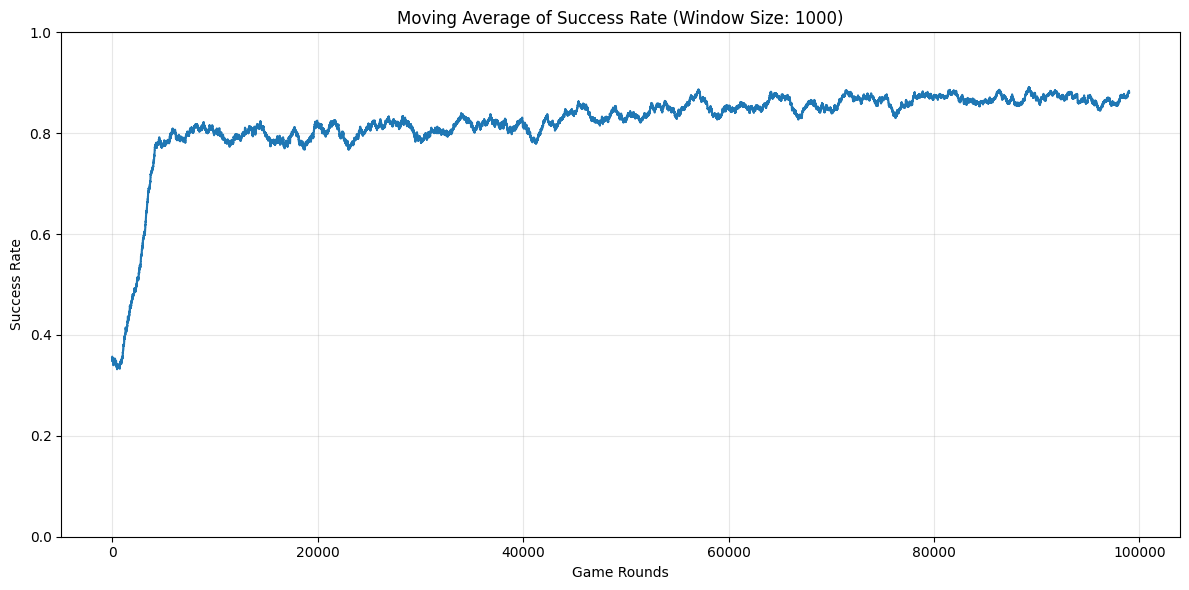

In [121]:
#| echo: false

plot_moving_average(game7, window_size=1000)

### Interpretation of the emergent messaging protocol

Since we cannot reproduce the weights convergence plots as in the previous symbolic signalling game, we will try to interpret the messaging protocol by looking at the mutual information heatmaps between each attribute and each position in the message, only for successful games.

The general ideas is that we will have a high mutual information between an attribute and a message position if that position reliably encodes that attribute. For example, if the second position of the message always encodes color, then the mutual information between color and the second message position will be high. We also want to see if each attribute is encoded in a separate position, which would point to a disentangled protocol.

In [122]:
#| echo: false

import numpy as np
import matplotlib.pyplot as plt

def plot_mi_heatmaps(game, only_success=True):
    digits = []
    colors = []
    sizes = []
    messages = []

    for s in game.stats:
        if only_success and s["p"] != 1:
            continue

        # Target is assumed to be (digit, color, size)
        digits.append(s["target"][0])
        colors.append(s["target"][1])
        sizes.append(s["target"][2])
        messages.append(s["m"])

    if len(messages) == 0:
        print("No samples available for plotting.")
        return

    messages = np.array(messages)
    digits = np.array(digits)
    colors = np.array(colors)
    sizes = np.array(sizes)

    T = game.maximum_message_length
    V = game.vocabulary_size

    attributes = [
        ("digit", digits, game.input_dims[0]),
        ("color", colors, game.input_dims[1]),
        ("size", sizes, game.input_dims[2]),
    ]

    # Plot heatmaps
    for attr_name, attr_values, attr_cardinality in attributes:
        for t in range(T):
            # Count matrix
            M = np.zeros((attr_cardinality, V))

            for a, m in zip(attr_values, messages):
                token = m[t]
                M[a, token] += 1

            # Normalize rows to get P(token_t | attribute)
            row_sums = M.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1.0
            M = M / row_sums

            # Plotting
            plt.figure(figsize=(10, 4))
            plt.imshow(M, aspect="auto", cmap="viridis")

            plt.xlabel("Message token")
            plt.ylabel(attr_name)
            plt.title(f"P(token_{t} | {attr_name})")

            # Discrete ticks
            plt.xticks(np.arange(V), np.arange(V))
            plt.yticks(np.arange(attr_cardinality), np.arange(attr_cardinality))

            # Grid to separate each cell
            plt.gca().set_xticks(np.arange(-0.5, V, 1), minor=True)
            plt.gca().set_yticks(np.arange(-0.5, attr_cardinality, 1), minor=True)
            plt.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
            plt.tick_params(which="minor", bottom=False, left=False)

            plt.colorbar()
            plt.tight_layout()
            plt.show()

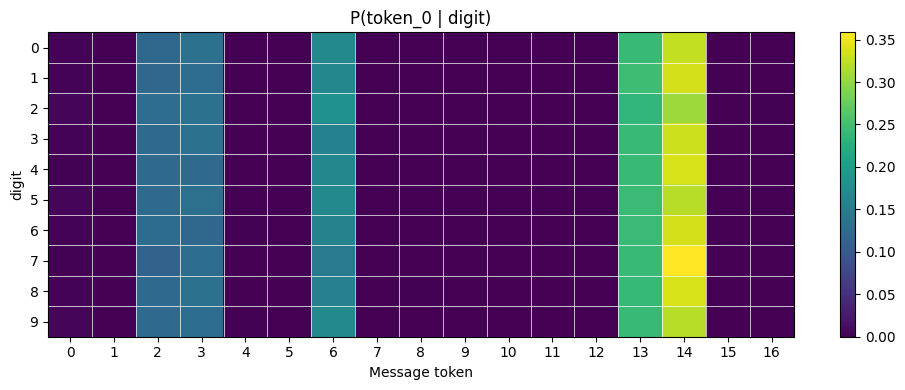

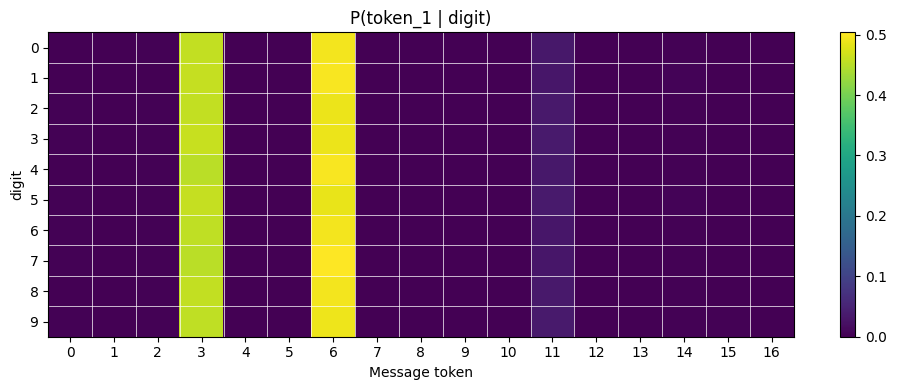

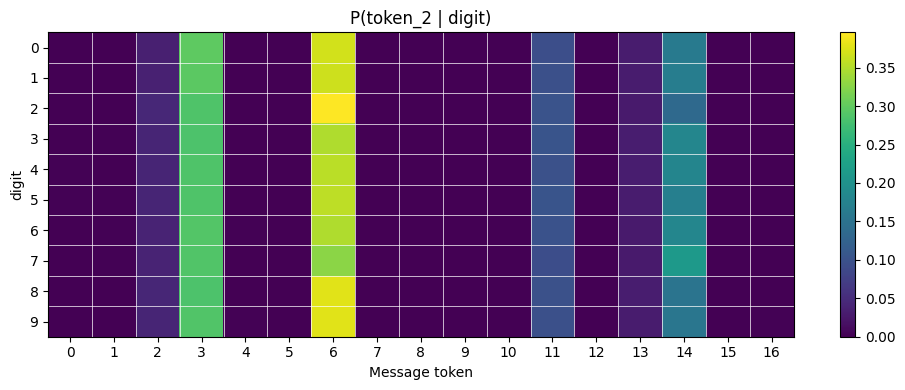

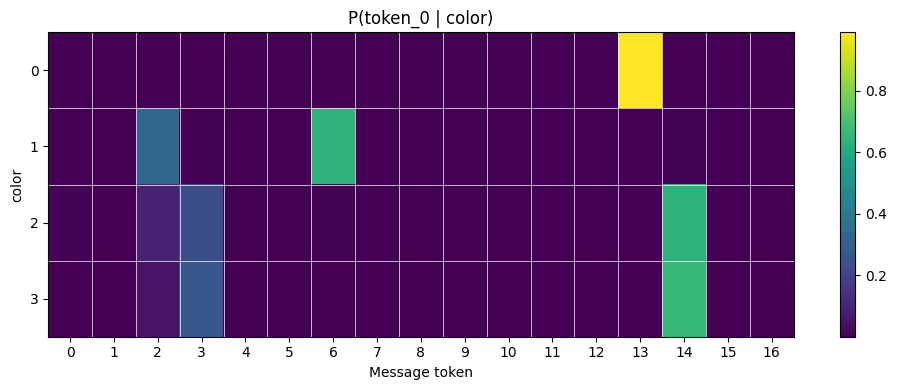

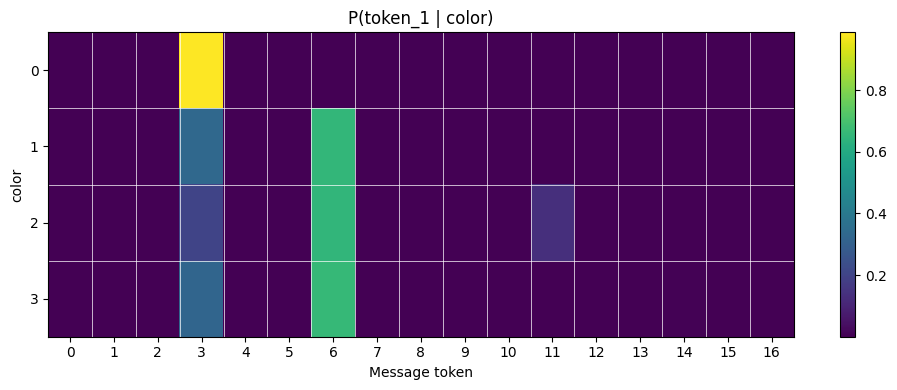

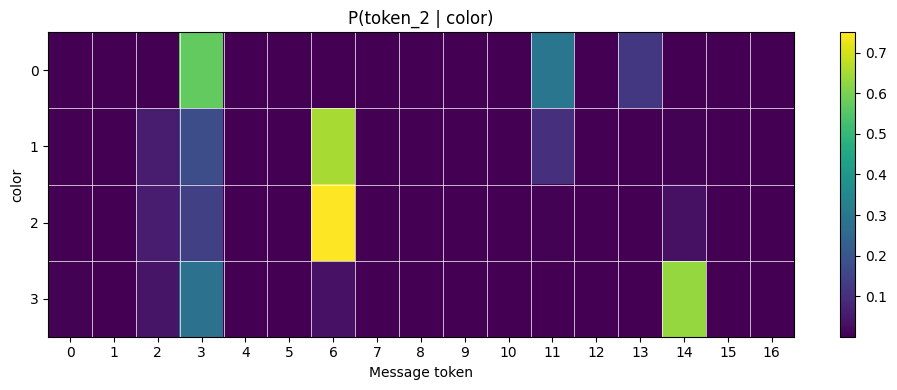

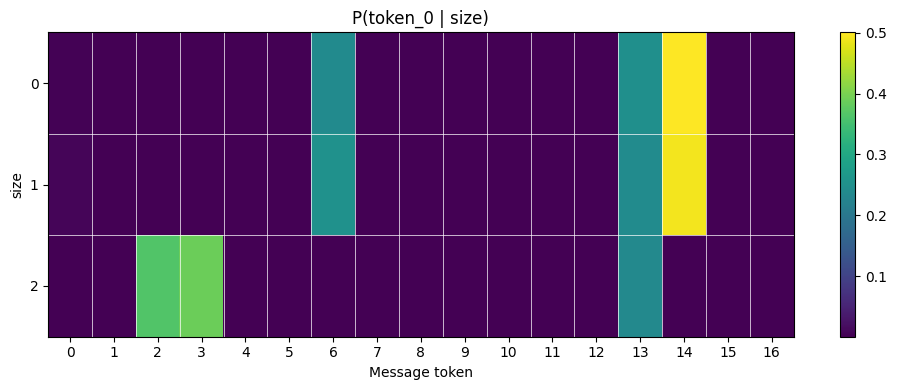

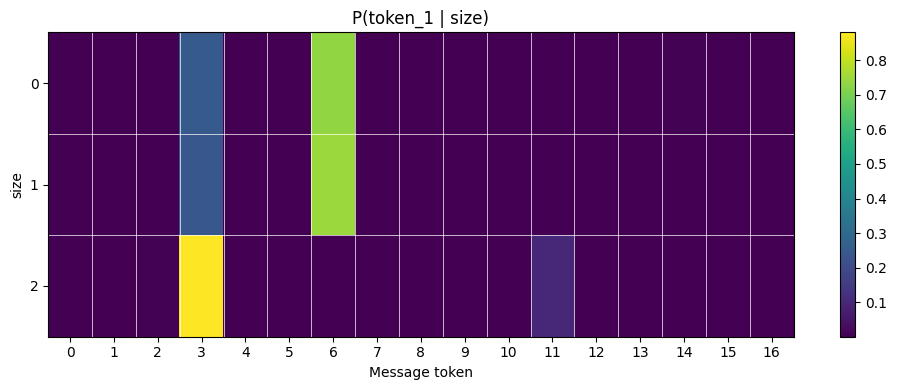

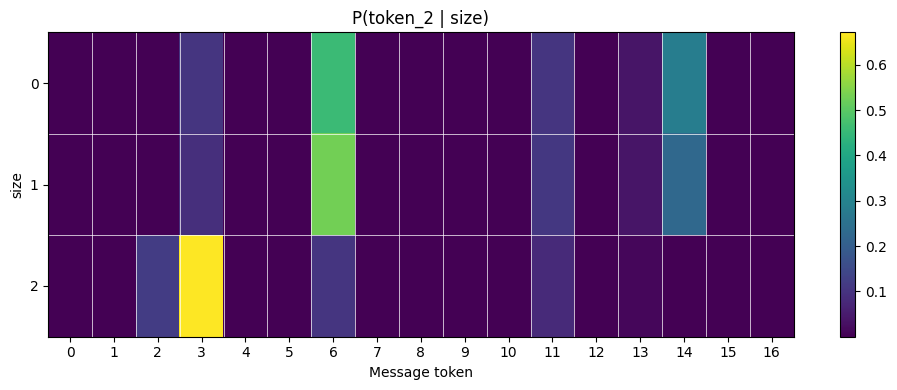

In [ ]:
#| echo: false

plot_mi_heatmaps(game7, only_success=True)

We can see a couple of things from the heatmaps above. First of all, there is no clear disentanglement of the attributes in the message positions. The mutual information is spread across many positions for each attribute. However, there are clear peaks of mutual information for each attribute, indicating that some positions do encode some attributes more than others. This can be a sign that the model is slowly establishing a protocol, but it is not yet clear-cut. It can also be a factor of the maximum message length and the vocabulary size. We picked those values because they matched the symbolic signalling game's message space size, but perhaps increasing them would allow for a clearer protocol to emerge. Despite that we have some clear parts that are interpretable: for example Alice reliably encodes large size with the symbol '3' at the second position. At the same position, color '2' is reliably encoded with the symbol '6'. Overall, we can say that not only is our game successful but also fairly interpretable!

## Preparing for the referential game

Now we will move from symbolic representations of the objects to actual images. We will use the MNIST dataset to represent digits and color them with the same colors as before. The size attribute will be represented by scaling the images. This is the classic referential game setup that we find in the literature.

### Create a randomized coloured and scaled MNIST dataset

First example: (<PIL.Image.Image image mode=L size=28x28 at 0x334CAB470>, 5), an object of <class 'tuple'>.


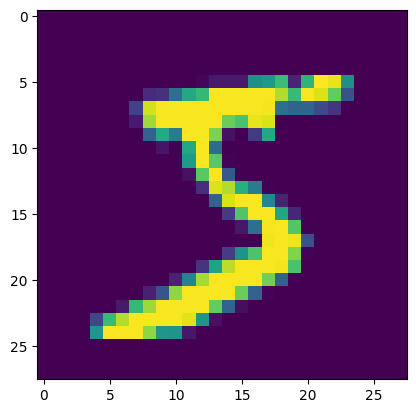

In [126]:
from torchvision.datasets import MNIST

dataset = MNIST("data", download=True)
print(f"First example: {dataset[0]}, an object of {type(dataset[0])}.")
plt.imshow(dataset[0][0])
plt.show()

Turn the image to a standard torch tensor.

In [127]:
from torchvision.transforms.functional import pil_to_tensor

img_tensor = pil_to_tensor(dataset[0][0])
print(img_tensor.shape)

torch.Size([1, 28, 28])


Helper functions to create images of different sizes and colors.

In [128]:
from torchvision.transforms import Pad, Resize

def scale_transform(image_tensor, scale_code):
    padded = Pad(10 * scale_code, fill=0)(image_tensor)
    scaled = Resize((28, 28))(padded)
    return scaled


def color_transform(image_tensor, color_code):
    coloured = torch.zeros((3, 28, 28), dtype=torch.float32)

    color_channels = {
        "red": 0,
        "green": 1,
        "blue": 2
    }

    if color_code not in color_channels:
        raise ValueError(f"Invalid color code: {color_code}. Must be 'red', 'green', or 'blue'")

    coloured[color_channels[color_code]] = image_tensor
    return coloured


def color_scale(image_tensor, color_code="green", scale_code=0):
    return scale_transform(color_transform(image_tensor, color_code), scale_code)

Create a randomized dataset.

In [129]:
import random
from torchvision.transforms import ToTensor

# Configuration
COLORS = ["red", "green", "blue"]
SIZES = [0, 1, 2]
labels = []
def randomize_tensorize_img(img_label_pair):
    img = ToTensor()(img_label_pair[0])
    color = random.choice(COLORS)
    size = random.choice(SIZES)
    labels.append((img_label_pair[1], color, size))
    return color_scale(img, color_code=color, scale_code=size)

# Transform entire dataset: random colors and sizes
mnist_colors = torch.stack([randomize_tensorize_img(item) for item in dataset])

### Auto-encoder

Now to build an auto-encoder.

To get an image vector, we will use a primitive method for encoding the images. First we get a raw vector by flattening the image matrices (one matrix for each channel) and then these three vectors are concatenated.

Then we perform dimension reduction by using a simple auto-encoder. An auto-encoder is a neural network whose task it to predict its input. The key feature is that the auto-encoder maps the input to a low dimension vector and then maps this low dimension representation again to the input dimension. In its simplest form it takes the form of a feed-forward network trained with an MSE loss.

In [130]:
from tqdm import tqdm


class MNISTAutoencoder(torch.nn.Module):
    def __init__(self, input_dim=2352, latent_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder: input_dim -> 128 -> latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, latent_dim)
        )

        # Decoder: latent_dim -> 128 -> input_dim
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_dim),
            torch.nn.Sigmoid()  # Output in [0, 1] range
        )


    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed


    def encode(self, image):
        # Handle single image or batch
        if image.dim() == 3:
            image = image.unsqueeze(0)  # Add batch dimension

        # Flatten to (batch_size, input_dim)
        flattened = image.reshape(-1, self.input_dim)

        with torch.no_grad():
            encoded = self.encoder(flattened)

        return encoded.squeeze(0) if encoded.size(0) == 1 else encoded


    def train_autoencoder(self, dataset, batch_size=64, epochs=10, lr=1e-3, device="cpu"):
        self.to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        n_batches = len(dataset) // batch_size

        # Progress bar for batches
        progress_bar = tqdm(range(epochs), desc=f"Training over {epochs} epochs")

        for _ in progress_bar:
            self.train()  # Set to training mode
            total_loss = 0.0

            for batch_idx in range(n_batches):
                # Get batch and flatten
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch = dataset[start_idx:end_idx]
                x = batch.reshape(-1, self.input_dim).to(device)

                # Forward pass
                optimizer.zero_grad()
                x_reconstructed = self.forward(x)
                loss = criterion(x_reconstructed, x)

                # Backward pass
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * x.size(0)

            # Print epoch statistics
            avg_loss = total_loss / (n_batches * batch_size)
            progress_bar.set_postfix({'loss': f'{avg_loss:.6f}'})


    def save_model(self, filename):
        torch.save(self.state_dict(), filename)


    def load_model(self, filename, device="cpu"):
        self.load_state_dict(torch.load(filename, map_location=device))
        self.eval()  # Set to evaluation mode

We define 3 auto-encoders with different latent dimensions. Our intuition is that Alice's and Bob's performance will depend on how well the auto-encoder compresses the images. If the latent dimension is too small, the auto-encoder will not be able to reconstruct the images well and Alice and Bob will not be able to communicate effectively.

In [131]:
autoencoder_64 = MNISTAutoencoder(input_dim=2352, latent_dim=64)
autoencoder_64.train_autoencoder(mnist_colors, batch_size=64, epochs=10)

Training over 10 epochs: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it, loss=0.001294]


In [132]:
autoencoder_128 = MNISTAutoencoder(input_dim=2352, latent_dim=128)
autoencoder_128.train_autoencoder(mnist_colors, batch_size=64, epochs=10)

Training over 10 epochs: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it, loss=0.001144]


In [133]:
autoencoder_256 = MNISTAutoencoder(input_dim=2352, latent_dim=256)
autoencoder_256.train_autoencoder(mnist_colors, batch_size=64, epochs=10)

Training over 10 epochs: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it, loss=0.001057]


## Referential game with images

We can now move on and define our game.

### The idea

Alice and Bob interact through a continuous communication channel of dimension $d_m$, referred to as the thinking dimension. Raw pictures are first mapped into a latent perceptual representation by our pretrained autoencoder. Each picture is thus represented as a vector $x_i \in \mathbb{R}^{d_p}$, where $d_p$ is the autoencoder latent dimension. This perceptual space is shared by Alice and Bob by design, so both agents reason about objects using the same latent picture representations.

At each episode, Alice observes only the latent representation of the target picture $x_t \in \mathbb{R}^{d_p}$. Alice implements a stochastic policy over messages by mapping this target representation into a separate continuous communication space. Two linear mappings produce a mean vector $\mu(x_t) \in \mathbb{R}^{d_m}$ and a log-standard-deviation vector $\log \sigma(x_t) \in \mathbb{R}^{d_m}$, defining a diagonal Gaussian distribution over the message space. A message $m \in \mathbb{R}^{d_m}$ is then sampled using the reparameterization trick, and its log-probability $\log p_A(m \mid x_t)$ is computed for policy-gradient learning.

Bob receives the continuous message $m \in \mathbb{R}^{d_m}$ and must interpret it in order to select the target picture. Because messages and pictures live in different vector spaces, Bob first applies a linear projection $W : \mathbb{R}^{d_m} \rightarrow \mathbb{R}^{d_p}$, mapping the message into the picture latent space and producing a vector $\hat m \in \mathbb{R}^{d_p}$. For each candidate picture $x_i \in \mathbb{R}^{d_p}$ in the current state, Bob computes a compatibility score given by the dot product $\langle x_i, \hat m \rangle$. These $K$ scores are normalized with a softmax to define a categorical distribution over picture indices, from which Bob samples an action. The log-probability of the sampled action $\log p_B(a \mid m)$ is recorded. Alice and Bob are trained jointly using a policy-gradient objective with sparse binary rewards, similar to the baseline symbolic signalling game. Our experiments have found that there is no need to add a baseline for the REINFORCE.

### The implementation

In [142]:
import torch
import numpy as np
from tqdm import tqdm

class ReferentialGame(torch.nn.Module):
    def __init__(
        self,
        K,
        dataset_pictures: torch.Tensor,
        autoencoder,
        thinking_dim=16,
        lr=0.5,
        batch_size=20,
        seed=42,
    ):
        super().__init__()
        self.K = K
        self.dataset_pictures = dataset_pictures
        self.autoencoder: MNISTAutoencoder = autoencoder
        self.thinking_dim = thinking_dim
        self.input_dim = autoencoder.latent_dim
        self.rng = np.random.RandomState(seed)
        self.batch_size = batch_size
        self.stats = []

        # Alice: defines a Gaussian policy over continuous messages conditioned on target picture latent representation
        self.alice_mu = torch.nn.Linear(self.input_dim, self.thinking_dim)
        self.alice_log_std = torch.nn.Linear(self.input_dim, self.thinking_dim)

        # Bob: maps received continuous messages back into picture latent space to score candidate pictures
        self.bob_emb = torch.nn.Linear(self.thinking_dim, self.input_dim)

        # Optimizer jointly updates parameters of Alice and Bob
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)


    def world_state(self):
        # Sample K distinct pictures without replacement from the dataset
        pictures_id = self.rng.choice(len(self.dataset_pictures), self.K, replace=False)
        target = self.rng.randint(self.K)
        return pictures_id, target


    def emit_message(self, pictures, target):
        target_repr = pictures[target]

        # Compute Gaussian policy parameters: mean vector for message distribution
        mu = self.alice_mu(target_repr)
        mu = torch.tanh(mu)

        # Compute Gaussian policy parameters
        # Log standard deviation vector, clamped for numerical stability
        log_std = self.alice_log_std(target_repr)
        log_std = torch.clamp(log_std, min=-5.0, max=5.0)
        std = torch.exp(log_std)

        # Define the Gaussian distribution for the message
        dist_alice = torch.distributions.Normal(mu, std)

        # Sample message using reparameterization trick for gradient flow
        message = dist_alice.rsample()

        # Compute log-probability of the sampled message for REINFORCE gradient estimation
        log_prob_alice = dist_alice.log_prob(message).sum(dim=-1)

        return message, log_prob_alice


    def perform_action(self, pictures, message):
        # Project the received continuous message back into picture latent space
        message_understood = self.bob_emb(message)

        # Compute similarity scores (dot product) between message embedding and each candidate picture
        scores = [torch.dot(p, message_understood) for p in pictures]
        scores = torch.stack(scores)

        # Define categorical distribution over picture indices based on scores
        dist_bob = torch.distributions.Categorical(logits=scores)

        # Sample chosen picture index according to the distribution
        chosen_pic = dist_bob.sample()

        # Compute log-probability of the chosen picture for REINFORCE gradient estimation
        log_prob_bob = dist_bob.log_prob(chosen_pic)

        return chosen_pic.item(), log_prob_bob


    def payoff(self, target, action):
        return 1 if action == target else 0


    def run_batch(self, batch_n: int):
        self.optimizer.zero_grad()
        batch_loss = torch.zeros(())

        for _ in range(batch_n):
            # One episode of the game
            pictures_id, target_id = self.world_state()
            seen_pictures = self.autoencoder.encode(self.dataset_pictures[pictures_id])
            message, log_prob_alice = self.emit_message(seen_pictures, target_id)
            action, log_prob_bob = self.perform_action(seen_pictures, message)
            reward = torch.tensor(float(self.payoff(target_id, action)), dtype=torch.float32)
            self.stats.append({"pics": pictures_id, "t": target_id, "p": int(reward.item()), "m": message})

            # Accumulate REINFORCE loss
            loss = -reward * (log_prob_alice + log_prob_bob)
            batch_loss = batch_loss + loss

        # Perform a single gradient update step for the whole batch
        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play_batch(self, N):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in tqdm(range(num_batches), desc="Training batches"):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)

We tested our implementation with different hyperparameters. The following worked best:

In [143]:
AUTOENCODER = autoencoder_128
THINKING_DIM = 16
LEARNING_RATE = 0.5
BATCH_SIZE = 100

In [144]:
game8 = ReferentialGame(
    K=3,
    dataset_pictures=mnist_colors,
    autoencoder=AUTOENCODER,
    thinking_dim=THINKING_DIM,
    lr=LEARNING_RATE,
    batch_size=BATCH_SIZE
)

game8.play_batch(100000)

Training batches: 100%|██████████| 1000/1000 [01:59<00:00,  8.40it/s]


In [137]:
#| echo: false

import pandas as pd

def longer_look(game, training_steps):
    training_steps = int(training_steps)
    
    payoffs = [x["p"] for x in game.stats]
    answer_labels = [labels[s["pics"][s["t"]]] for s in game.stats]
    
    accuracy = sum(payoffs) / len(payoffs) * 100
    print(f"Overall accuracy: {accuracy:.2f}%")
    
    correct_payoffs = sum(payoffs[training_steps:]) / len(payoffs[training_steps:])
    correct_accuracy = correct_payoffs * 100
    print(f"Accuracy after {training_steps} steps: {correct_accuracy:.2f}%")
    
    # Initialize performance tracking
    performance = {
        'digit': {i: {'correct': 0, 'total': 0} for i in range(10)},
        'color': {color: {'correct': 0, 'total': 0} for color in COLORS},
        'size': {size: {'correct': 0, 'total': 0} for size in SIZES}
    }
    
    # Aggregate results
    for payoff, (digit, color, size) in zip(payoffs, answer_labels):
        performance['digit'][digit]['total'] += 1
        performance['color'][color]['total'] += 1
        performance['size'][size]['total'] += 1
        
        if payoff:
            performance['digit'][digit]['correct'] += 1
            performance['color'][color]['correct'] += 1
            performance['size'][size]['correct'] += 1
    
    # Build dataframe
    rows = []
    for feature_type, feature_dict in performance.items():
        for feature_value, stats in feature_dict.items():
            success_rate = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
            rows.append({
                'Feature': feature_type,
                'Value': feature_value,
                'Correct': stats['correct'],
                'Total': stats['total'],
                'Success_Rate': f"{success_rate:.2f}%"
            })
    
    df = pd.DataFrame(rows)
    return df

We have very high accuracy, and the model converges quite fast!

In [ ]:
#| echo: false

detailed_performance = longer_look(game8, 100000*0.01)

Overall accuracy: 96.49%
Accuracy after 1000 steps: 96.94%


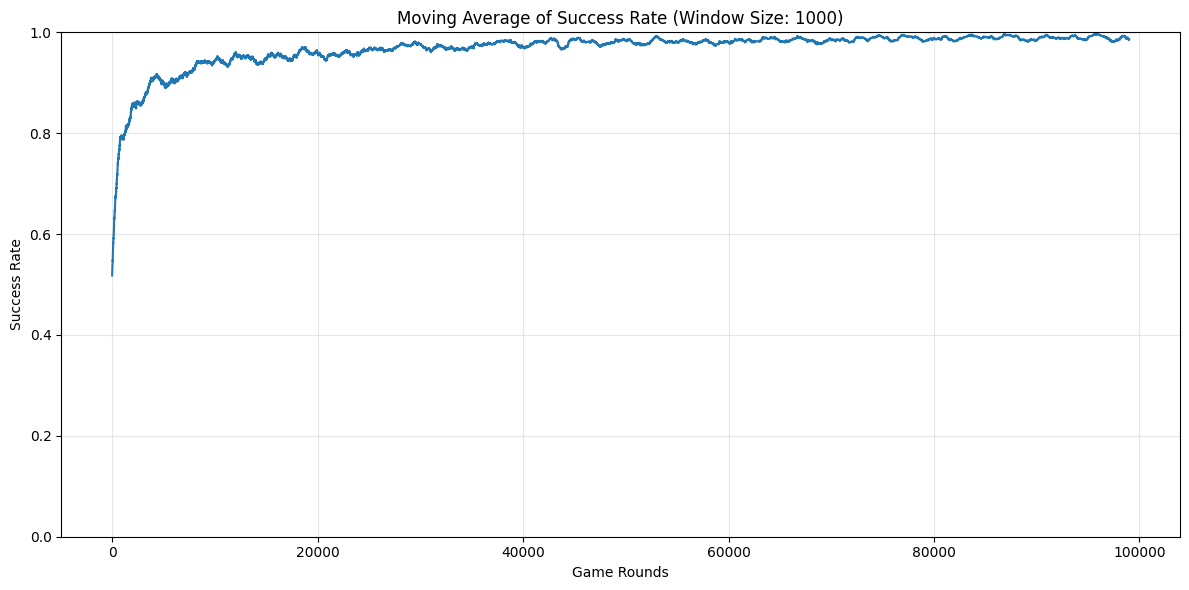

In [146]:
#| echo: false

plot_moving_average(game8, window_size=100000*0.01)

We can also have a breakdown of the performance per digit, color and size.

In [ ]:
#| echo: false

from IPython.core.display import Markdown

Markdown(detailed_performance.to_markdown(index=False))

| Feature   | Value   |   Correct |   Total | Success_Rate   |
|:----------|:--------|----------:|--------:|:---------------|
| digit     | 0       |      9603 |    9926 | 96.75%         |
| digit     | 1       |     10913 |   11293 | 96.64%         |
| digit     | 2       |      9598 |    9940 | 96.56%         |
| digit     | 3       |     10021 |   10366 | 96.67%         |
| digit     | 4       |      9332 |    9640 | 96.80%         |
| digit     | 5       |      8674 |    9060 | 95.74%         |
| digit     | 6       |      9407 |    9754 | 96.44%         |
| digit     | 7       |     10015 |   10401 | 96.29%         |
| digit     | 8       |      9412 |    9758 | 96.45%         |
| digit     | 9       |      9512 |    9862 | 96.45%         |
| color     | red     |     31643 |   32784 | 96.52%         |
| color     | green   |     32597 |   33764 | 96.54%         |
| color     | blue    |     32247 |   33452 | 96.40%         |
| size      | 0       |     32160 |   33070 | 97.25%         |
| size      | 1       |     32309 |   33595 | 96.17%         |
| size      | 2       |     32018 |   33335 | 96.05%         |

The above results indicate that Alice and Bob can successfully communicate about all attributes of the images: digit, color, and size. The accuracy is high across all attributes, suggesting that the emergent communication protocol is effective in conveying the necessary information for Bob to correctly identify the target image based on Alice's message. The question thus becomes? Can we interpret the continuous "code" that Alice uses to represent each attribute in her messages?

### Interpretation of the emergent messaging protocol

To attempt at interpreting Alice’s messages, we average the continuous message activations over successful trials and compare, for each attribute value, the mean activation pattern across message dimensions to the global average, allowing us to identify dimensions that are selectively modulated by specific object features. We provide our commets after the plots.

In [149]:
#| echo: false

import torch

def interpretation(game, feature='digit'):
    DIGITS = range(10)
    COLORS = ["red", "green", "blue"]
    SIZES = [0, 1, 2]

    if feature == 'digit':
        feature_values = list(DIGITS)
    elif feature == 'color':
        feature_values = COLORS
    else:
        feature_values = SIZES

    payoffs = [x["p"] for x in game.stats]
    answer_labels = [labels[s["pics"][s["t"]]] for s in game.stats]

    # Get indices of successful trials
    successful_indices = [i for i, success in enumerate(payoffs) if success]

    # Extract and process messages
    messages = [torch.nn.functional.softmax(s["m"], dim=0) for s in game.stats]
    messages = torch.stack(messages).detach().numpy()

    # Filter for successful trials only
    successful_labels = np.array(answer_labels)[successful_indices]
    successful_messages = messages[successful_indices]

    # Map feature to index in label tuple
    feature_index = {'digit': 0, 'color': 1, 'size': 2}[feature]
    message_dim = successful_messages.shape[1]

    avg_total_activations = [successful_messages[:, i].mean() for i in range(message_dim)]

    # Plot for each feature value
    for value in feature_values:
        # Filter messages for this feature value
        value_str = str(value)
        matching_messages = successful_messages[
            [i for i, label in enumerate(successful_labels) if label[feature_index] == value_str]
        ]

        if len(matching_messages) == 0:
            print(f"{feature.capitalize()} {value}: No successful trials")
            continue

        # Calculate average activation per message dimension
        avg_activations = [matching_messages[:, i].mean() for i in range(message_dim)]

        # Plot using plt.stem for the desired effect
        plt.figure(figsize=(10, 4))
        # Plot global average as a reference (dashed lines)

        # Plot specific feature average (solid lines, circles)
        plt.bar(x=range(message_dim), height=avg_activations)
        plt.stem(range(message_dim), avg_total_activations, linefmt='C1:', markerfmt='D', basefmt=' ', label='Overall Average')

        plt.title(f'Average Message Pattern for {feature.capitalize()} {value}')
        plt.xlabel('Message Dimension')
        plt.ylabel('Average Activation')
        plt.xticks(range(message_dim))
        plt.ylim([0, max(avg_activations) * 1.1])
        plt.grid(True, alpha=0.3, axis='y')
        plt.legend()
        plt.tight_layout()
        plt.show()

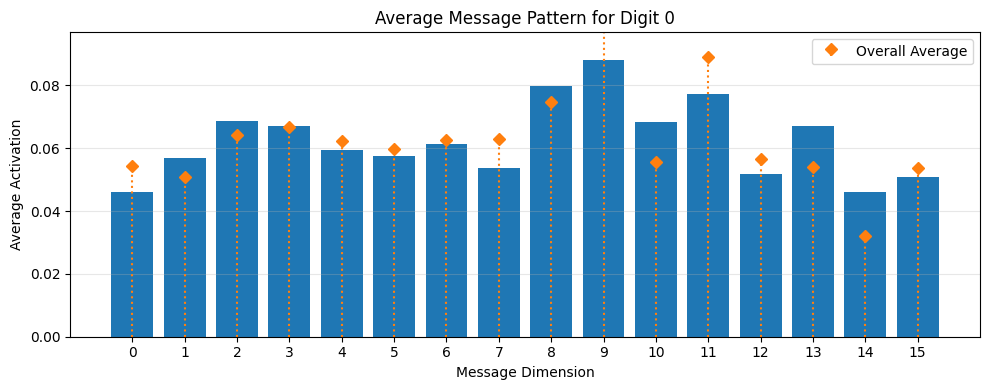

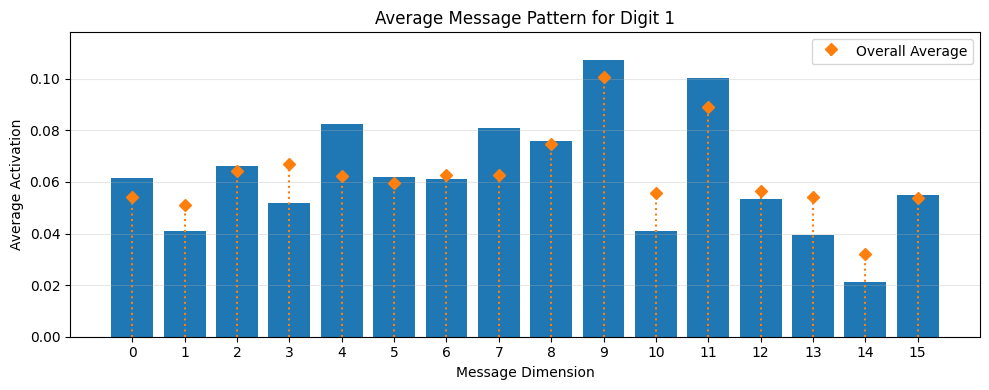

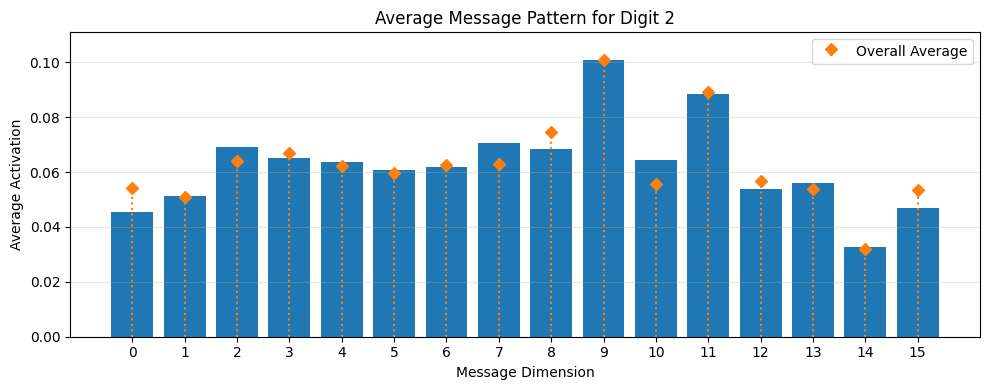

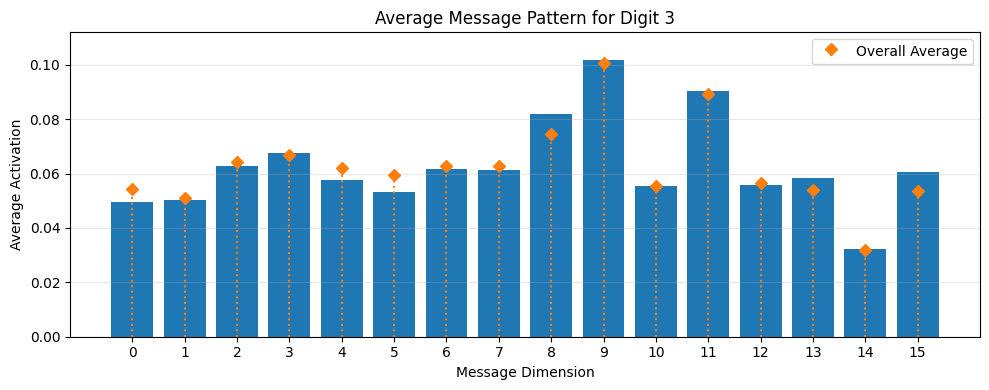

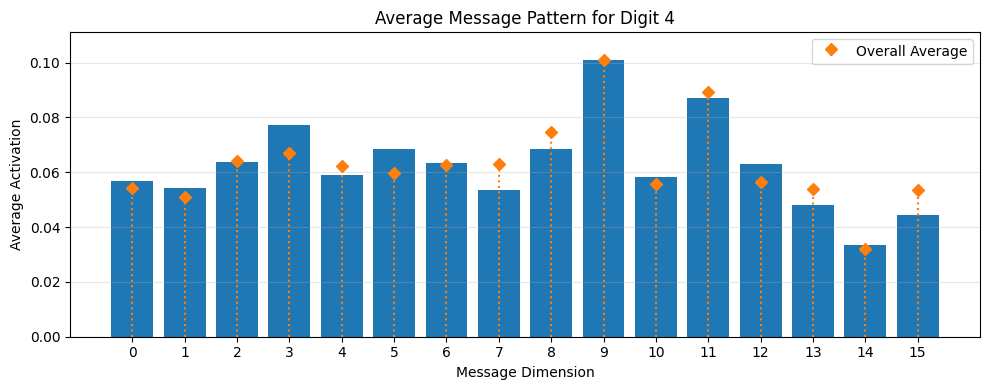

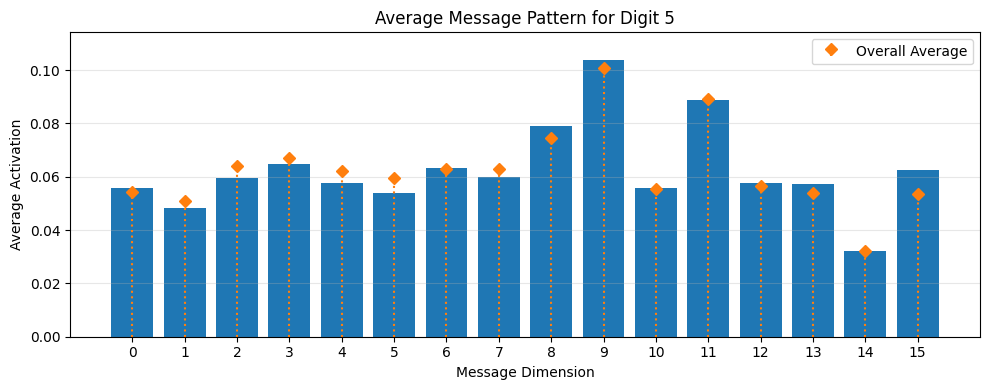

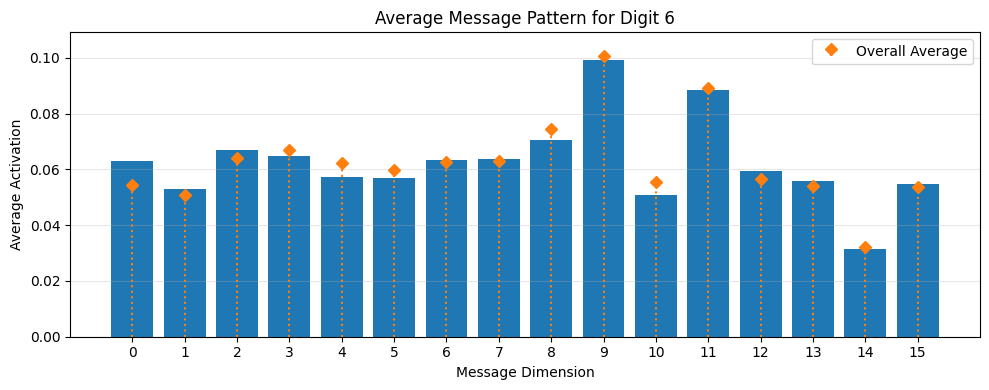

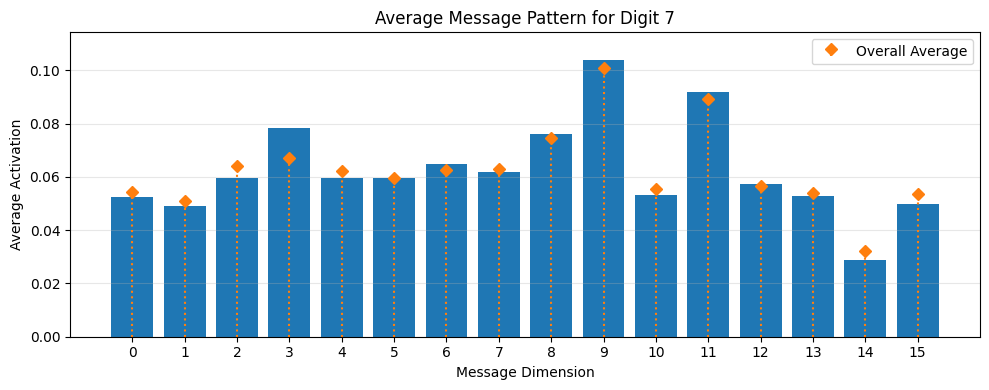

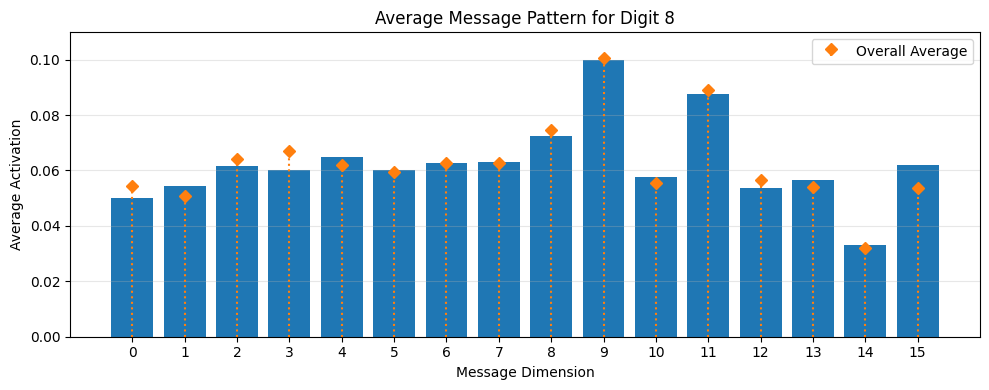

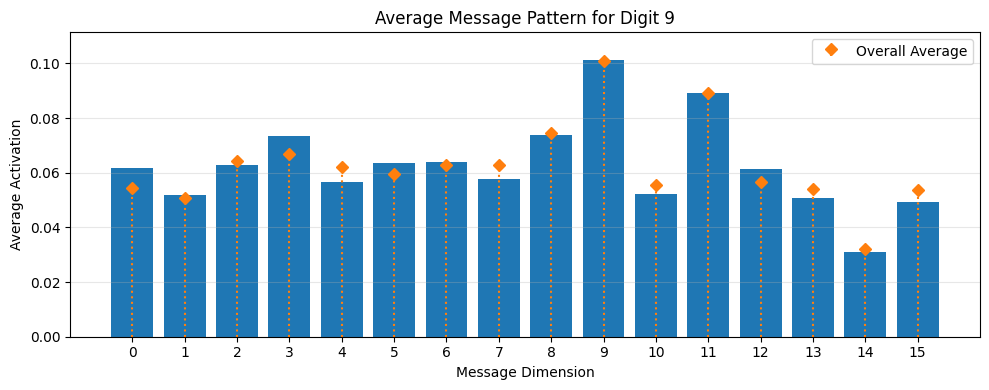

In [151]:
#| echo: false

interpretation(game8, feature='digit')

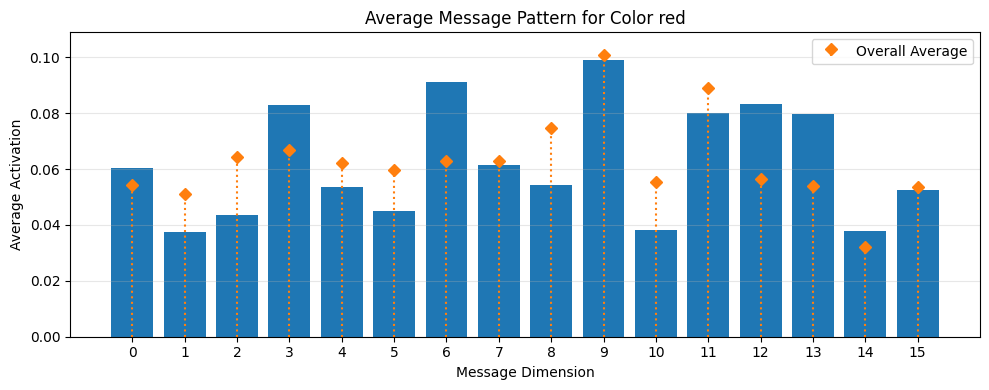

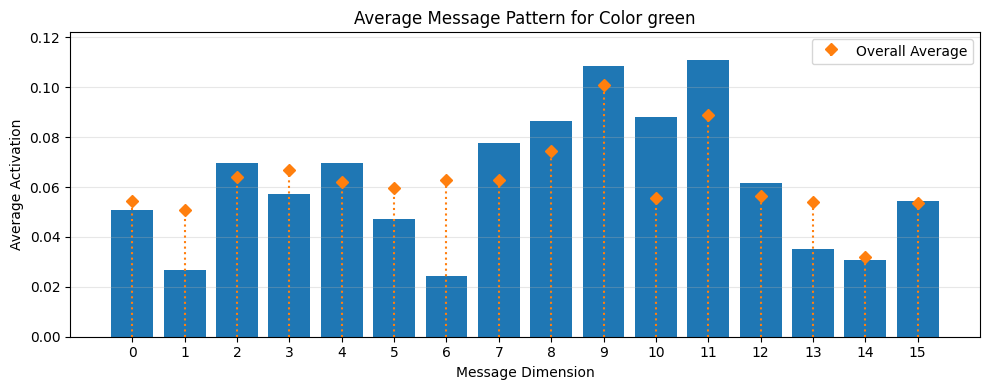

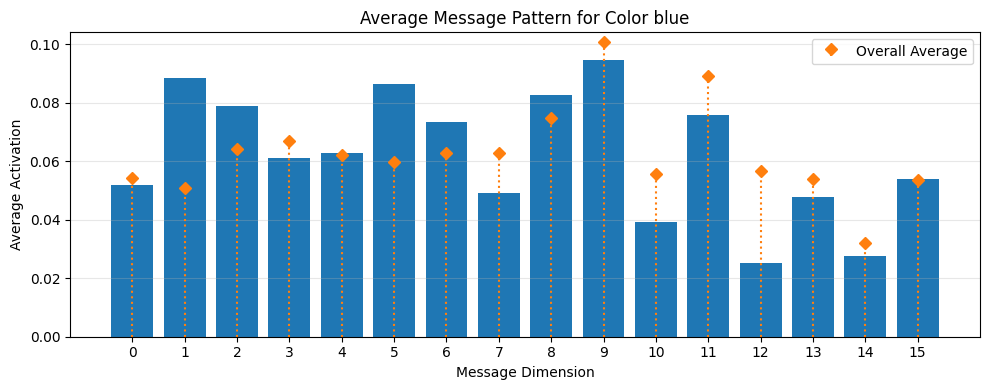

In [152]:
#| echo: false

interpretation(game8, feature='color')

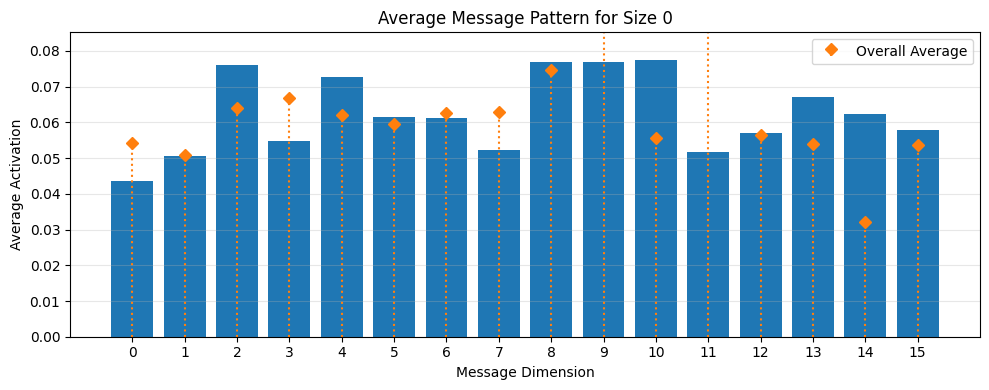

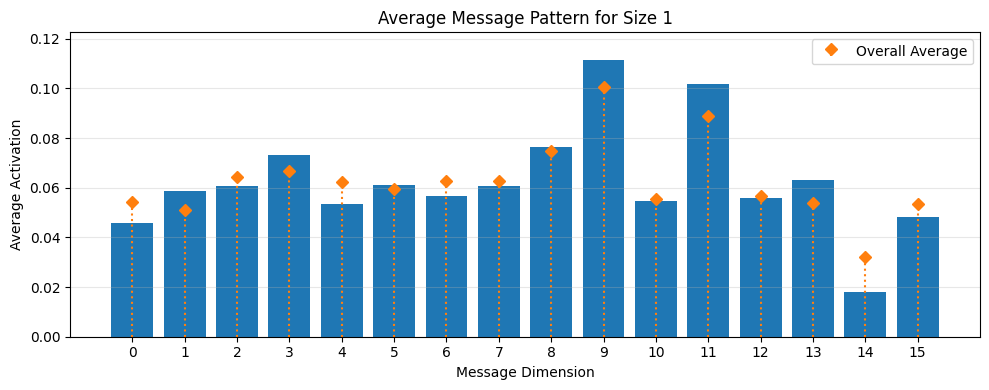

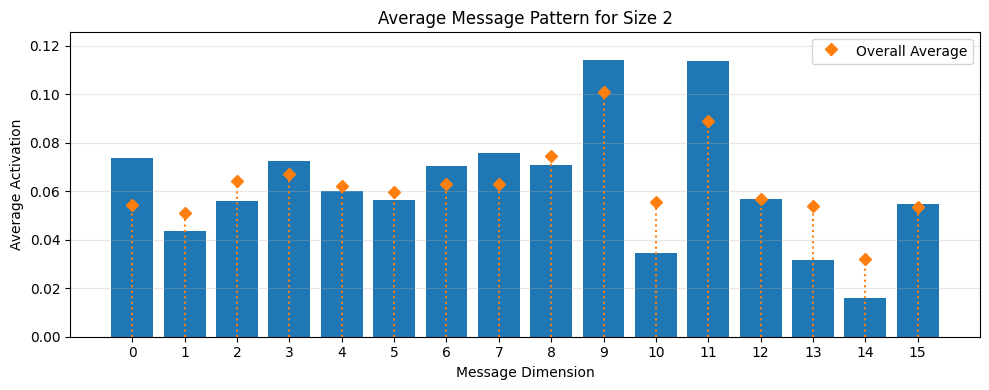

In [153]:
#| echo: false

interpretation(game8, feature='size')

Increasing the output dimension of the encoder (and thus the input dimension of the model) amounts to increasing its capacity to perceive and represent information clearly. What we have called the thinking dimension, also understood as the communication dimension, corresponds to the encoding capacity of the message. A theoretically ideal dimension for a binary encoding (with message vector coordinates taking values 0 or 1) would be 16: ten possible digits, three colors, and three sizes, that is, three ones and thirteen zeros to represent the object in a one-hot–like manner. A less efficient alternative would use a dimension of 90, where each coordinate corresponds directly to a specific Digit–Color–Size triple. With a thinking size equal to the input size, Alice could transmit the received data to Bob without modification, and beyond that size one can consider that she would merely be adding unnecessary complexity.

For better interpretability and to avoid misleading conclusions, we considered average activation values. As the number of dimensions increases, these average values decrease (for a message size of 8, averages were around 0.2, and for 16 they were around 0.1). Consequently, it is not the absolute value of a message coordinate that matters, but rather its deviation from the mean: a value can only be considered high if it is higher than usual. By default, activations are unevenly distributed, as clearly observed.

The diversity of message patterns reveals a form of specialization. Colors and sizes appear much easier for the model to diversify, which is intuitively reasonable, and one often observes a single neuron being much more strongly activated than the others. Our results suggest that regardless of the thinking dimension, the model struggles to represent digits in a visually well-separated manner (in the plots). This indicates that the more categories a property has, the less visually salient it becomes when isolated in this way.

Overall, the model seems to have statistically chosen to concentrate the information of a given property in specific coordinates. However, due either to limited capacity or to the absence of an explicit heuristic enforcing full separation, information is sometimes distributed across combinations of coordinates, and we also observe a form of negative encoding. For instance, the “large” size (size 0) is expressed by a neuron whose activation is markedly lower than all others (neuron 11), as if it were signalling “not large”; this neuron is then above average for smaller sizes. Is this some form of negation emergence?

We identify the following possible improvements: (1) modifying the relative size differences during dataset generation to examine what the model can most easily learn, and (2) analysing not only the message itself but also Bob’s specific responses to individual parameters within the message.